#### In this notebook we are going to use spaCy to find out what customers are complaining about

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
# download english language model
!python -m spacy download en_core_web_lg

In [ ]:
# download transformers
pip install -q transformers

In [68]:
# download wordcloud
pip install wordcloud

SyntaxError: invalid syntax (820721949.py, line 2)

In [ ]:
from transformers import pipeline

In [6]:
reviews = pd.read_csv('data/biz_review_3-5.csv')

In [7]:
reviews_text = reviews['text'].str.lower()

### 1. Complaints about food
#### One focus will be on finding customer complaints about food.
#### To do so, we will use a table with food labels and train spaCy to recognize them.

In [2]:
import spacy

In [ ]:
food_df = pd.read_csv('data/food_labels.csv')

In [ ]:
food_labels = food_df[food_df['description'].str.contains('[a-zA-Z]') == True]['description']

In [ ]:
food_labels = food_labels[food_labels.str.split().apply(len) <= 2].drop_duplicates()

In [ ]:
food_labels = food_labels.str.lower()

In [ ]:
food_labels = food_labels[food_labels.str.contains('.*,.*,.*', regex=True) == False]

In [ ]:
# Fix: Foods are comma seperated and order is reversed: 'muffins, blueberry' become 'blueberry muffins'

food_labels[food_labels.str.contains(', ') == True] = (
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(', ') == True].str.split(', ', expand=True)[0]
)

food_labels[food_labels.str.contains(',') == True] = (
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[1] +
    ' ' +
    food_labels[food_labels.str.contains(',') == True].str.split(',', expand=True)[0]
)

In [12]:
# If label has no plural, create singular form. If label has no singular, create plural 

import lemminflect

nlp = spacy.load('en_core_web_lg')

inflected_labels = []

for label in food_labels:
    
    doc = nlp(label)

    if len(doc) == 1:
        if doc[0].tag_ == 'NNS':
            inflected_labels.append(doc[0]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0]._.inflect('NNS'))

    if len(doc) == 2:
        if doc[1].tag_ == 'NNS':
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NN'))
        else:
            inflected_labels.append(doc[0].text + ' ' + doc[1]._.inflect('NNS'))

ModuleNotFoundError: No module named 'lemminflect'

In [ ]:
food_labels_inflected = pd.Series(inflected_labels)

In [ ]:
food_labels = pd.concat([food_labels, food_labels_inflected])

In [ ]:
food_labels.drop_duplicates(inplace=True)

In [ ]:
# Add food labels to entity ruler

food_labels = food_labels  # Remove 'bar' from foods_labels, add 'product'

patterns = []

nlp = spacy.load('en_core_web_lg')

ruler = nlp.add_pipe('entity_ruler', before='ner')

for label in food_labels:
    patterns.append({'label': 'FOOD', 'pattern': label})

ruler.add_patterns(patterns)

In [ ]:
ruler.to_disk('data/food_patterns.jsonl')

#### We can now use the matcher to look for specific word patterns

In [3]:
from spacy.matcher import Matcher

In [4]:
# The function takes as arguments:
# model=spaCy language model, must be stringformat
# file=PandasSeries with strings to analyse
# pattern=Patterns to look for
# ruler=an entity ruler with additional entity labels, optional, must be a path in string format referring to a jsonl file
# The name of the matcher in capital letters

def match_reviews(model, file, pattern, matcher_name, ruler_path=None):

   from spacy.matcher import Matcher
    
   nlp = spacy.load(model)

   if ruler_path:
      ruler = nlp.add_pipe("entity_ruler", before='ner')
      ruler.from_disk(ruler_path)
 
   matcher = Matcher(nlp.vocab)

   matcher.add(matcher_name, pattern, greedy='LONGEST')

   matches_temp = []
   matches = []

   for text in file:
      doc=nlp(text)
      matches_temp = matcher(doc)
      if matches_temp != []:
         for match in matches_temp:
            matches.append({'keyword': doc[match[1]:match[2]].text})

   return matches

In [ ]:
model = 'en_core_web_sm'
file = reviews_text[:1000]
pattern = [
    [
        {'ENT_TYPE': 'FOOD'},
        {'LEMMA': {'IN': ['be', 'taste', 'smell']}},
        {'DEP': 'neg', 'OP': '?'},
        {'POS': 'ADV', 'OP': '?'},
        {'POS': 'ADJ'}
    ]
]
matcher_name = 'FOOD_MATCHER'
ruler_path = 'data/food_patterns.jsonl'

food_matches = match_reviews(model, file, pattern, matcher_name, ruler_path)

### 2. Complaints about service
#### We also would like to know what customers are complaining about service.

In [31]:
model = 'en_core_web_lg'

file = reviews_text[:1000]

# create pattern contains multiple patterns
pattern = [
[
    {'POS': 'ADJ', 'OP': '*'},
    {"LOWER": {"in": ['boss', 'waiter', 'waitress', 'hostess', 'waiters', 'owner', 'waitresses', 'service', 'staff', 'waitstaff', 'cook', 'manager', 'bartender']}}, 
    {'POS': 'ADV', 'OP': '*'},
    {"POS": {"in": ['VERB', 'be', 'seem']}},
    {'POS': 'ADV', 'OP': '*'},    
    {'POS': 'NOUN', 'OP': '*'}, 
    {'POS': 'ADP', 'OP': '*'},
    {'POS': 'PROPN', 'OP': '*'},
    {'POS': 'VERB', 'OP': '*'},
    {'POS': 'ADJ'}
   ], 
   [{'POS': 'ADJ', 'OP': '*'},
    {"LOWER": {"in": ['boss', 'waiter', 'waitress', 'hostess', 'waiters', 'owner', 'waitresses', 'service', 'staff', 'waitstaff', 'cook', 'manager', 'bartender']}}, 
    {"LEMMA": 'be', 'OP': '*'},
    {'POS': 'ADV', 'OP': '*'},    
    {"LOWER": {"in": ['rude', 'bad', 'worse', 'worst', 'awful', 'disgusting', 'terrible', 'horrible', 'slow', 'disappointed', 'disappointing', 'poor', 'unpleasant', 'inattentive', 'unfriendly', 'unresponsive', 'not friendly', 'inconsistent', 'clueless',]}},
   ],
   [
    {'POS': 'ADV', 'OP': '*'}, 
    {'POS': 'ADJ'},
    {"LOWER": {"in": ['boss', 'waiter', 'waitress', 'hostess', 'waiters', 'owner', 'waitresses', 'service', 'staff', 'waitstaff', 'cook', 'manager', 'bartender']}}, 
   ],
   [
    {'POS': 'ADJ', 'OP': '*'},
    {"LOWER": {"in": ['boss', 'waiter', 'waitress', 'hostess', 'waiters', 'owner', 'waitresses', 'service', 'staff', 'waitstaff', 'cook', 'manager', 'bartender']}},  
    {'LEMMA': 'be not'},
    {'POS': 'ADJ'}
   ],
   [
    {'POS': 'PROPN'},
    {'LEMMA': 'ignore'},
    {'POS': 'PROPN', 'OP': '*'},
   ]
]

matcher_name = 'SERVICE_MATCHER'

service_matches = match_reviews(model, file, pattern, matcher_name)

The results contains negative and positive ones, we will run sentiment analysis one more time to sort the negative keywords. 

In [55]:
# convert service keywords to a df
service_matches_df = pd.DataFrame(service_matches)

# select the pipeline
sentiment_pipeline = pipeline(model="mrcaelumn/yelp_restaurant_review_sentiment_analysis")

service_kw_results = pd.DataFrame(columns=['keyword', 'result'])

# loop each row(review)
for review in service_matches_df['keyword']:
    try:
        # processing by the model
        for result in sentiment_pipeline(review):
            row_review = pd.DataFrame({'review': [review], 'result': [result]})
        service_kw_results = pd.concat([service_kw_results, row_review], ignore_index=True)
# the model can not processing long text (dont know how long), but this will skip the error
    except Exception as e:
        print(f"Error processing text: {review}. Error: {e}")
        continue

### write to csv
service_kw_results.to_csv('service_kw_results.csv', index=False)

In [15]:
service_kw_results = pd.read_csv('service_kw_results.csv')

In [17]:
# clean the result df
 
# split 2 columns
service_kw_results[['result', 'score']] = service_kw_results['result'].str.split(',', expand=True)
 # remove some symbols
service_kw_results['result'] = service_kw_results['result'].str.replace("{'label': '", "") # remove 
service_kw_results['result'] = service_kw_results['result'].str.replace(": '", "")
service_kw_results['result'] = service_kw_results['result'].str.replace("'", "")
service_kw_results['score'] = service_kw_results['score'].str.replace("'score': ", "")
service_kw_results['score'] = service_kw_results['score'].str.replace("}]", "")
service_kw_results['score'] = service_kw_results['score'].str.replace("}", "")

In [18]:
# convert label to text for better reading
service_kw_results['result'] = service_kw_results['result'].str.replace("LABEL_2", "Positive")
service_kw_results['result'] = service_kw_results['result'].str.replace("LABEL_1", "Neutral")
service_kw_results['result'] = service_kw_results['result'].str.replace("LABEL_0", "Negative")

We created wordcloud for the frequent words in the negative reviews. 

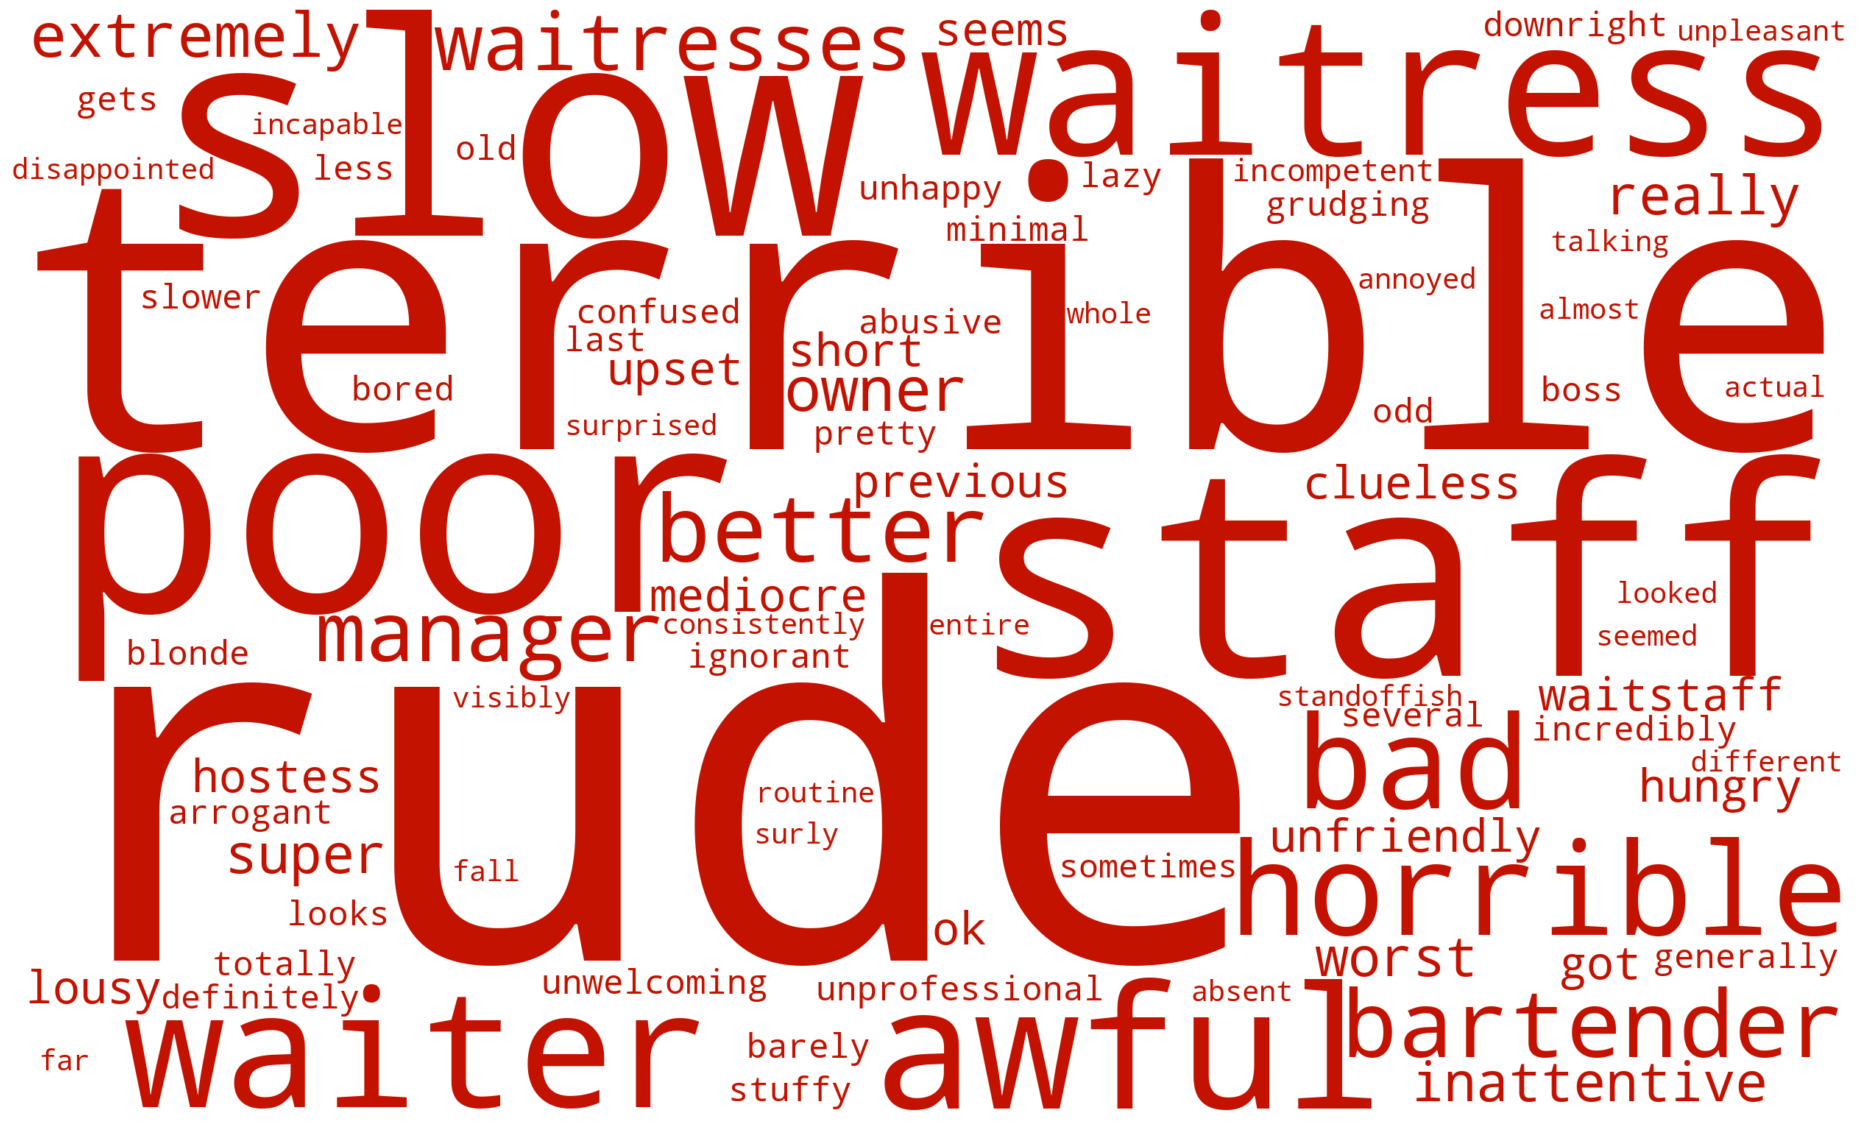

In [19]:
## create a new df with negative keywords only
service_kw_results_neg = service_kw_results[service_kw_results['result'] == "Negative"]

service_kw_neg = " ".join(word for word in service_kw_results_neg.review)

# Create stopword list, and add the word service
stopwords = ['service'] + list(STOPWORDS)

plt.figure(figsize=(11.87*2, 7.42*2))

# Generate a word cloud image
service_wc = WordCloud(width=2500, height=1500, stopwords=stopwords, background_color='white', prefer_horizontal=1.5, color_func=lambda *args, **kwargs: (196,18,0)).generate(service_kw_neg)

# Display the generated image:
# the matplotlib way:
plt.imshow(service_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 3. Complaints Ambience & Location

In [70]:
model = 'en_core_web_lg'

file = reviews_text[:1000]

# create pattern contains multiple patterns
pattern = [
[
    {'POS': 'ADV', 'OP': '*'},
    {"LOWER": {"in": ['dirty', 'loud', 'noisy', 'ugly', 'old', 'broken', 'crowded', 'boring', 'dark']}},
    {'LEMMA': 'be', 'OP': '*'},   
    {'POS': 'NOUN'},
   ], 
   [
    {"LOWER": {"in": ['place', 'table', 'vibe', 'dishes', 'people', 'space', 'music', 'bathroom', 'toilet', 'design', 'interior', 'plates']}},
    {'LEMMA': 'be'},
    {'POS': 'ADV', 'OP': '*'},
    {'POS': 'ADJ'}
   ]
]

matcher_name = 'AMBIENCE_MATCHER'

ambience_matches = match_reviews(model, file, pattern, matcher_name)

In [84]:
# convert keywords to a df
ambience_matches_df = pd.DataFrame(ambience_matches)

ambience_kw_results = pd.DataFrame(columns=['keyword', 'result'])

# loop each row(review)
for review in ambience_matches_df['keyword']:
    try:
        # processing by the model
        for result in sentiment_pipeline(review):
            row_review = pd.DataFrame({'review': [review], 'result': [result]})
        ambience_kw_results = pd.concat([ambience_kw_results, row_review], ignore_index=True)
# the model can not processing long text (dont know how long), but this will skip the error
    except Exception as e:
        print(f"Error processing text: {review}. Error: {e}")
        continue

### write to csv
ambience_kw_results.to_csv('ambience_kw_results.csv', index=False)

In [8]:
ambience_kw_results = pd.read_csv('ambience_kw_results.csv')

In [9]:
# clean the result df
 
# split 2 columns
ambience_kw_results[['result', 'score']] = ambience_kw_results['result'].str.split(',', expand=True)

 # remove some symbols
ambience_kw_results['result'] = ambience_kw_results['result'].str.replace("{'label': '", "") # remove 
ambience_kw_results['result'] = ambience_kw_results['result'].str.replace(": '", "")
ambience_kw_results['result'] = ambience_kw_results['result'].str.replace("'", "")
ambience_kw_results['score'] = ambience_kw_results['score'].str.replace("'score': ", "")
ambience_kw_results['score'] = ambience_kw_results['score'].str.replace("}]", "")
ambience_kw_results['score'] = ambience_kw_results['score'].str.replace("}", "")

In [11]:
# convert label to text for better reading
ambience_kw_results['result'] = ambience_kw_results['result'].str.replace("LABEL_2", "Positive")
ambience_kw_results['result'] = ambience_kw_results['result'].str.replace("LABEL_1", "Neutral")
ambience_kw_results['result'] = ambience_kw_results['result'].str.replace("LABEL_0", "Negative")

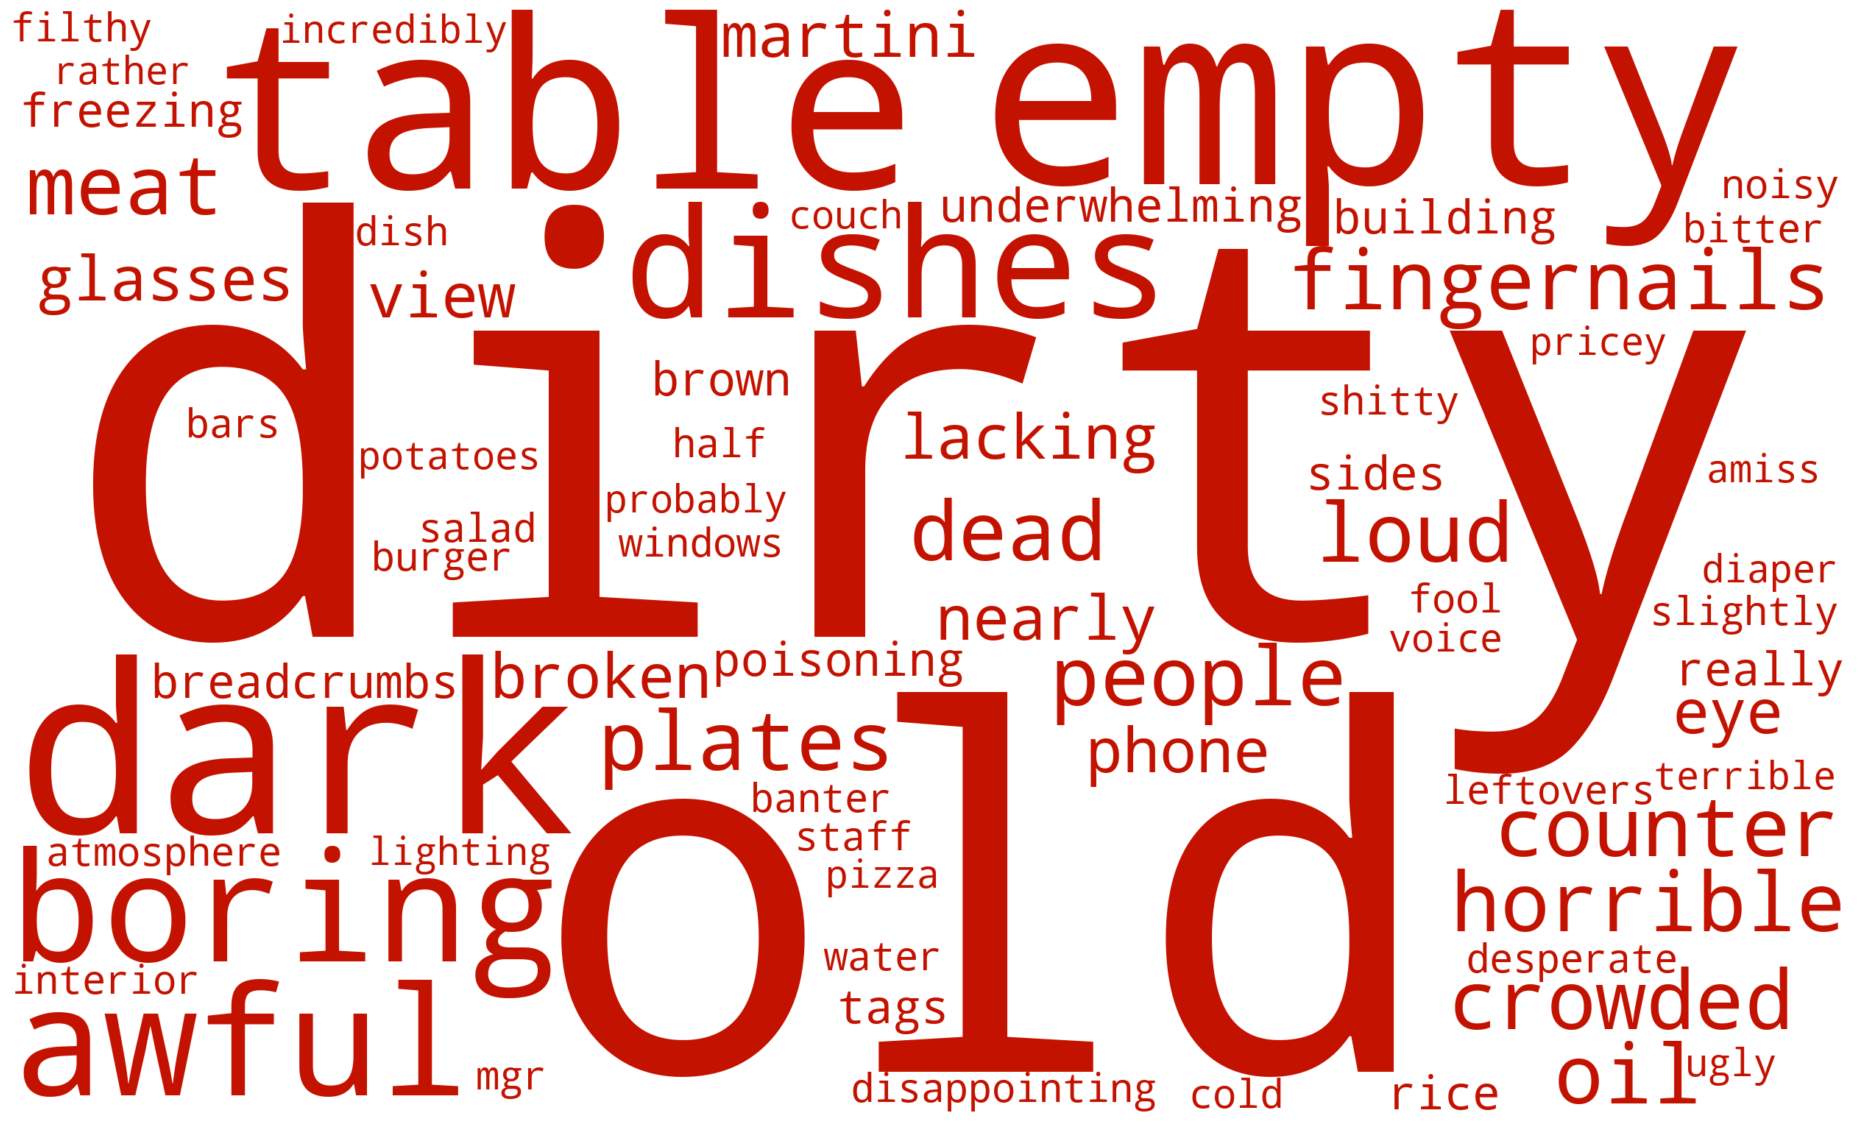

In [13]:
## create a new df 
ambience_kw_results_neg = ambience_kw_results[ambience_kw_results['result'] == "Negative"]

ambience_kw_neg = " ".join(word for word in ambience_kw_results_neg.review)

# Create stopword list, add place to stopwords list
stopwords = ['place'] + list(STOPWORDS)

plt.figure(figsize=(11.87*2, 7.42*2))

# Generate a word cloud image
ambience_wc = WordCloud(width=2500, height=1500, stopwords=stopwords, background_color='white', prefer_horizontal=1.5, color_func=lambda *args, **kwargs: (196,18,0)).generate(ambience_kw_neg)

# Display the generated image:
# the matplotlib way:
plt.imshow(ambience_wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 4. Price

In [22]:
model = 'en_core_web_lg'

file = reviews_text[:1000]

# create pattern contains multiple patterns
pattern = [[
    {"POS": 'NOUN'}, 
    {"LEMMA": 'be', 'OP': '*'},  
    {'POS': 'ADV', 'OP': '*'},
    {'POS': 'ADJ', 'OP': '*'},
    {"LOWER": {"in": ['pricy', 'overpriced', 'over priced', 'expensive', 'costly', 'price', 'steep', 'high', 'crazy', 'too much', 'pricier']}} 
]]

matcher_name = 'PRICE_MATCHER'

price_matches = match_reviews(model, file, pattern, matcher_name)

In [29]:
price_matches

[{'keyword': 'menu is pricy'},
 {'keyword': 'food was overpriced'},
 {'keyword': 'food is overpriced'},
 {'keyword': 'prices are high'},
 {'keyword': 'menu price'},
 {'keyword': 'drinks are expensive'},
 {'keyword': 'steakhouse is extremely overpriced'},
 {'keyword': 'food is unnecessarily overpriced'},
 {'keyword': 'steakhouses are expensive'},
 {'keyword': 'bowls are pretty much more expensive'},
 {'keyword': 'food is way overpriced'},
 {'keyword': 'prices are way high'},
 {'keyword': 'muffin is too steep'},
 {'keyword': 'food is incredibly overpriced'},
 {'keyword': 'samosas are now also more expensive'},
 {'keyword': 'price was pretty high'},
 {'keyword': 'way overpriced'},
 {'keyword': 'prices are way too high'},
 {'keyword': 'menu price'},
 {'keyword': 'menu is grossly overpriced'},
 {'keyword': 'drinks are expensive'},
 {'keyword': 'place is pretty expensive'},
 {'keyword': 'menu is overpriced'},
 {'keyword': 'baby high'},
 {'keyword': 'food was overpriced'},
 {'keyword': 'fries

In [30]:
price_matches_df = pd.DataFrame(price_matches)

In [32]:
price_matches_df

,keyword
0,menu is pricy
1,food was overpriced
2,food is overpriced
3,prices are high
4,menu price
5,drinks are expensive
6,steakhouse is extremely overpriced
7,food is unnecessarily overpriced
8,steakhouses are expensive
9,bowls are pretty much more expensive


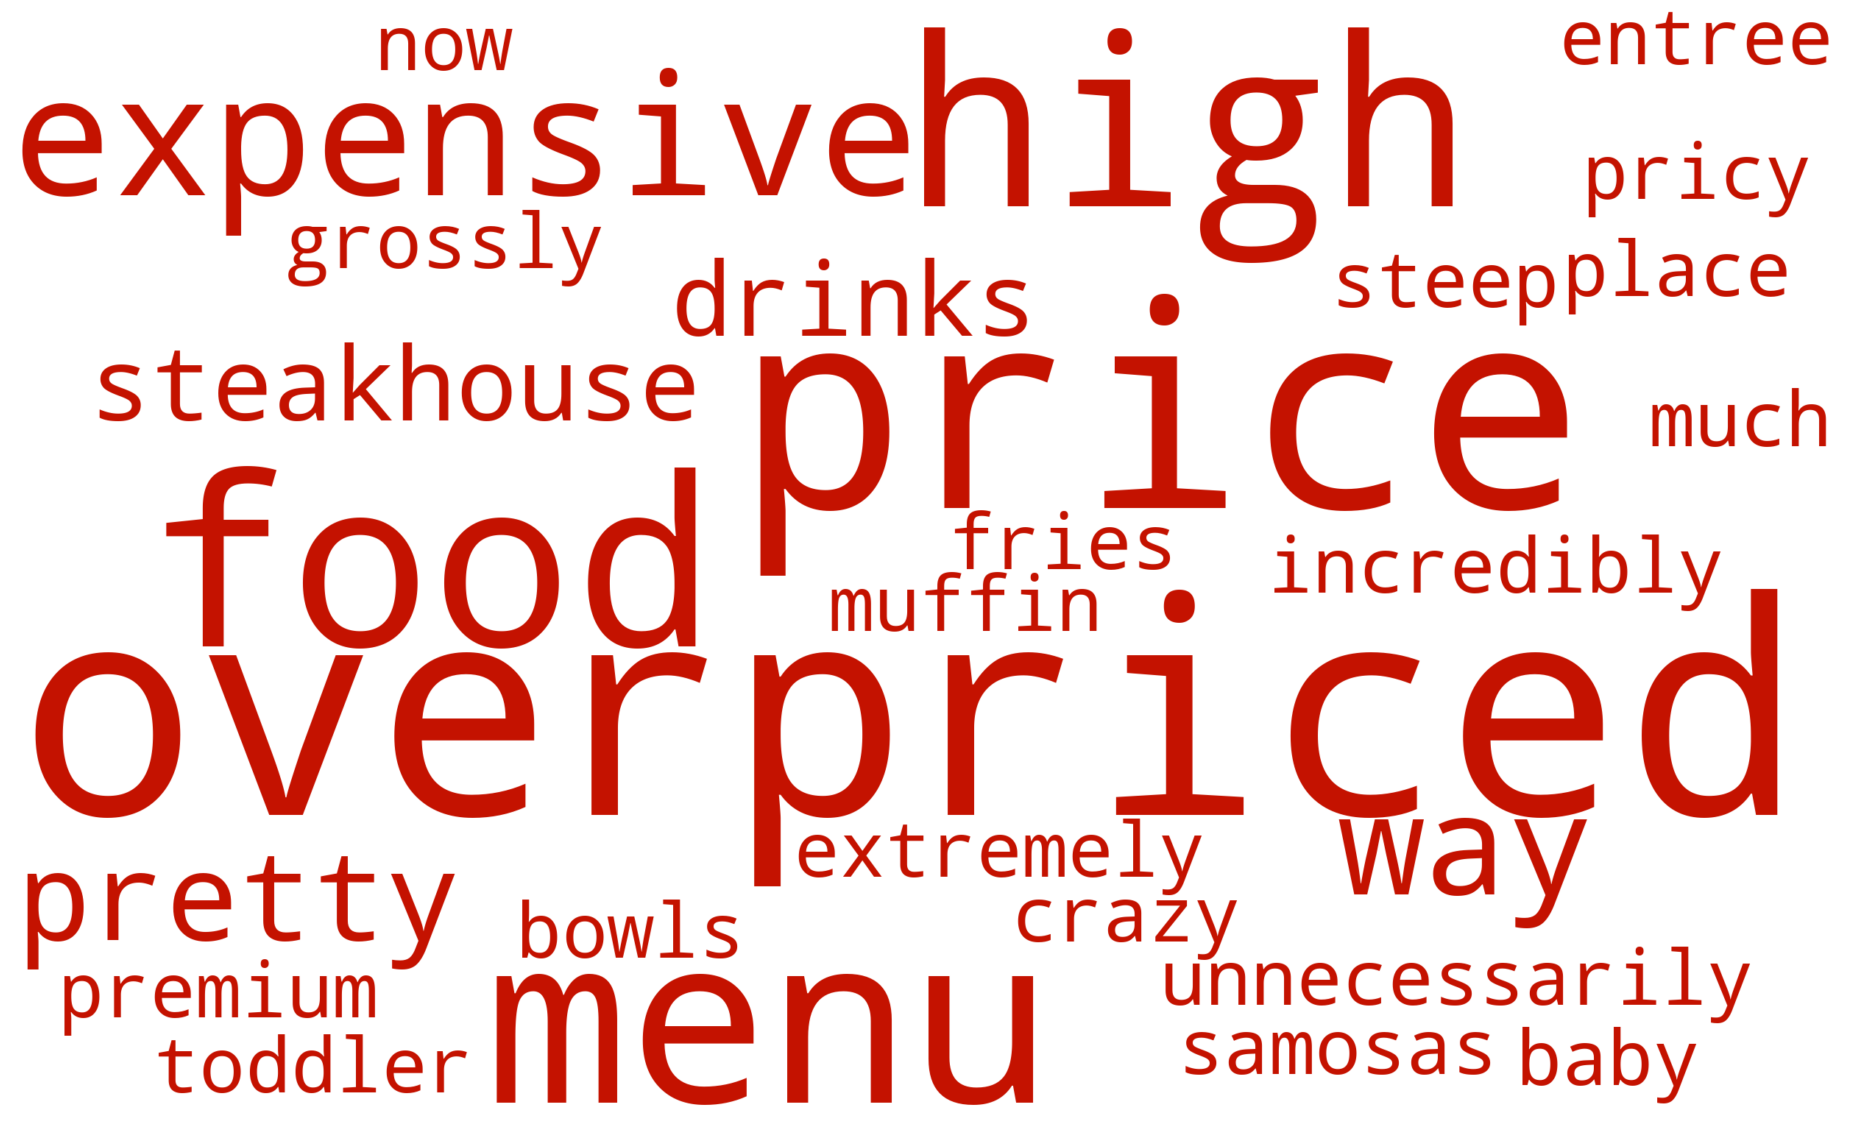

In [33]:
price_kw = " ".join(word for word in price_matches_df.keyword)

stopwords = STOPWORDS

plt.figure(figsize=(11.87*2, 7.42*2))

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color='white', prefer_horizontal=1.5, color_func=lambda *args, **kwargs: (196,18,0), width = 2500, height = 1500).generate(price_kw)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()